# <center>Part III Prediction</center>











**Installing openslide-tools**

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-4).
0 upgraded, 0 newly installed, 0 to remove and 275 not upgraded.


In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import pathlib
import pickle
import random
#!pip install opencv-python
import cv2

import seaborn as sns
import pandas as pd

In [3]:
#!pip install tensorflow
#%tensorflow_version 2.x
import tensorflow as tf

2021-12-30 11:55:48.546772: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/anaconda3/lib/python3.8/site-packages/cv2/../../lib64:
2021-12-30 11:55:48.546840: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

**Load the train model with history**

In [62]:
with open("120319_project_tumor_folder/20211227_trained_model_with_history_no_preprocessing.pkl", "rb") as f:
    model, history = pickle.load(f)
f.close()

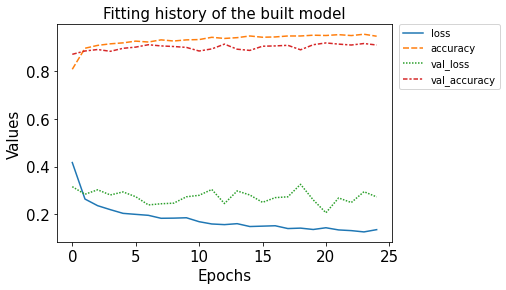

In [124]:
#plot history

plot_df = pd.DataFrame(history.history)

#plot_df.index = range(plot_df.shape[0])

plot = sns.lineplot(data=plot_df)

plt.title("Fitting history of the built model", size=15)
plt.xlabel("Epochs", size=15)
plt.ylabel("Values", size=15)
plt.xticks(size=15)
plt.yticks(size=15)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
  
plt.show()

<b> load all images and select 3 image as test set </b>

In [64]:
data_root = pathlib.Path(data_folder_path)
all_mask_paths = list(data_root.glob('*mask.tif'))
all_tif_paths = list(data_root.glob('*.tif'))
all_img_paths = set(all_tif_paths) - set(all_mask_paths)
all_mask_names = sorted([x.name.split("tumor_")[1].split(".")[0] for x in all_mask_paths])
all_img_names = sorted([x.name.split("tumor_")[1].split(".")[0] for x in all_img_paths])
print(all_mask_names)
print(all_img_names)
print(all_mask_paths)

['001_mask', '002_mask', '005_mask', '012_mask', '016_mask', '019_mask', '023_mask', '031_mask', '035_mask', '057_mask', '059_mask', '064_mask', '075_mask', '078_mask', '081_mask', '084_mask', '091_mask', '094_mask', '096_mask', '101_mask', '110_mask']
['001', '002', '005', '012', '016', '019', '023', '031', '035', '038', '057', '059', '064', '075', '078', '081', '084', '091', '094', '096', '101', '110']
[PosixPath('120319_project_tumor_folder/Copy of tumor_110_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_005_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_012_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_016_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_019_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_101_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_075_mask.tif'), PosixPath('120319_project_tumor_folder/Copy of tumor_059_mask.tif'), PosixPath('120319_project_tumor_folder/

In [65]:
#obtain test set
test_image_path = sorted([path_x for path_x in all_img_paths if np.sum([id in str(path_x) for id in ['096', '075', '091']])>0])
test_mask_path = sorted([path_x for path_x in all_mask_paths if np.sum([id in str(path_x) for id in ['096', '075', '091']])>0])


<b> Define functions for extract patches from test images, preprocess patches and make predicitons</b>

In [66]:
def path_to_slide(path):
    return open_slide(str(path))

test_slides = [path_to_slide(path) for path in test_image_path]
test_mask = [path_to_slide(path) for path in test_mask_path]
test_names = [path.name.split("Copy of ")[1] for path in test_image_path]


In [67]:
#check the center region 128*128 of a 299*299 patch, and return the boolean value indicates whether the center region of the patch has tumor or not
#Sum > 0 suggests existence of tumor pixel in the center region
def has_tumor_center_patch(mask, center_size=128, patch_size=299):
    edge = (patch_size - center_size) // 2

    return np.sum(mask[edge:center_size + edge, edge:center_size + edge]) > 0
def read_slide(slide, x, y, level, width=None, height=None, as_float=False):
    #slide = open_slide(str(slide_path))
    if width == None and height == None:
        width, height = slide.level_dimensions[level]
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

#define the function to obtain a patch from a slide
def get_patch(slide, tumor_mask, x, y, zoom_level, patch_size = 299):
    x = int(x)
    y = int(y)

    #actual edge is equal to patch_size times corresponding zoom level
    edge = int(patch_size // 2 * slide.level_downsamples[zoom_level])

    #slide read from the Top left corner of the patch
    slide_image = read_slide(slide,
                           x - edge, 
                           y - edge,
                           zoom_level,
                           width=patch_size,
                           height=patch_size)


    #take only the first dimension of [R, B, G] for the mask 
    mask_image = read_slide(tumor_mask,
                           x - edge, 
                           y - edge,
                           zoom_level,
                           width=patch_size,
                           height=patch_size)[:, :, 0]

    return slide_image, mask_image

#return the location of tissue pixels (2D) in an image slide
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

#return a new image with only tissue pixels showing in red color (255)
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask:
        masked[x][y] = color
    return masked


#function to extract tissues from the slide image, return a new image with only tissue pixels in red color
def extract_tissue(slide_image):
    return(apply_mask(slide_image, find_tissue_pixels(slide_image)))

#define function to get tissue ratio
def get_tissue_ratio(images, patch_size=299):
    tissue_pixels = find_tissue_pixels(images)
    tissue_ratio = float(len(list(tissue_pixels))) / patch_size**2
    return tissue_ratio


In [127]:
# create the rotation function to increase accuracy of the prediction
#Each test patch is first flipped, then 90, 180, 270 degrees rotations are performed individually 
#on the original or flipped patch, which results in 8 patches in total

def test_rotate(img, patch_size=299):
    
    flipped_img = tf.image.flip_left_right(img)
    
    new_imgs = [img, \
                tf.image.rot90(img, k=1, name=None).numpy().reshape((patch_size, patch_size, 3)),\
                tf.image.rot90(img, k=2, name=None).numpy().reshape((patch_size, patch_size, 3)),\
                tf.image.rot90(img, k=3, name=None).numpy().reshape((patch_size, patch_size, 3)),\
                flipped_img, \
                tf.image.rot90(flipped_img, k=1, name=None).numpy().reshape((patch_size, patch_size, 3)),\
                tf.image.rot90(flipped_img, k=2, name=None).numpy().reshape((patch_size, patch_size, 3)),\
                tf.image.rot90(flipped_img, k=3, name=None).numpy().reshape((patch_size, patch_size, 3)),\
               ]


    #return the list of new images
    return(new_imgs)



#function to make prediction on test image patches
#the final prediciton of a test patch is the average prediction value of all eight patches
def predict_patches(level1_img, level2_img, level1_mask, model, patch_size=299):
    
    y_label = [int(has_tumor_center_patch(mask_x)) for mask_x in level1_mask]
    
    
    y_pred = []
    
    #create flips and rotations for level1 and level2 test images
    for img1, img2 in zip(list(level1_img), list(level2_img)):
        
        new_level1_imgs = test_rotate(img1)
        new_level2_imgs = test_rotate(img2)
    
        
        y_pred.append(model.predict([np.array(new_level1_imgs), np.array(new_level2_imgs)]).mean())


    assert len(y_label) == len(y_pred)
    
    #y_pred = model.predict([level1_img, level2_img]).reshape(level1_img.shape[0],)

    #y_pred = [1 if x>0.5 else 0 for x in y_pred]

    #predict normal if the tisse ratio is less than 0.3

    for idx in range(len(y_pred)):
        if get_tissue_ratio(level2_img[idx])<=0.3:
            y_pred[idx] = 0
    
    #print(f"y_pred is {y_pred}")

    return np.array(y_pred), np.array(y_label)

  

In [128]:
def create_test_patch(slide, mask_slide, model, zoom_level1=0, zoom_level2=1, patch_size=299):

    zoom_level1_factor = slide.level_downsamples[zoom_level1]
    zoom_level2_factor = slide.level_downsamples[zoom_level2]


    #obtain the width and height of the zoom level 1
    (W1, H1) = slide.level_dimensions[zoom_level1]
    
    #calculate the total number of patches
    width_num_patches = int((W1 - patch_size * zoom_level1_factor) // (patch_size * zoom_level1_factor))
    height_num_patches = int((H1 - patch_size * zoom_level1_factor) // (patch_size * zoom_level1_factor))

    #intialize the prediction and ground truth label matrices
    prediction = np.zeros((width_num_patches, height_num_patches)).astype(float)
    actual = np.zeros((width_num_patches, height_num_patches)).astype(int)


    for i in range(width_num_patches):
        level1_patches = []
        level2_patches = []
        masks = []

        for j in range(height_num_patches):
            x = (patch_size // 2 * zoom_level1_factor) + i * patch_size * zoom_level1_factor
            y = (patch_size // 2 * zoom_level1_factor) + j * patch_size * zoom_level1_factor


            level1_patch, level1_mask = get_patch(slide, mask_slide, x, y, zoom_level1)
            level2_patch, level2_mask = get_patch(slide, mask_slide, x, y, zoom_level2)


            level1_patch = level1_patch / 255.
            level2_patch = level2_patch / 255.



            level1_patches.append(level1_patch)
            level2_patches.append(level2_patch)
            masks.append(level1_mask)

        if (i+1)%20 == 0:
            print(f"Finished {int((i+1)*height_num_patches)} out of {width_num_patches*height_num_patches}!")


  


        #make predictions and save predictions and ground truth labels
        prediction[i,:], actual[i,:] = predict_patches(level1_img = np.array(level1_patches), level2_img = np.array(level2_patches), level1_mask = np.array(masks), model=model)

    
        
    

    return prediction.T, actual.T


  




In [103]:
#make predictions for all test patches
for slide, mask, name in zip(test_slides, test_mask, test_names):
    
    
    
    name = name.split(".")[0]
    print(f"Now working on slide {slide}")
    print(f"Now working on mask {mask}")
    print(f"Now working on filename {name}")



    pre_test, act_test = create_test_patch(slide=slide, mask_slide=mask, model=model)


    with open(f"120319_project_tumor_folder/122821_test_predictions_of_{name}_no_preprocessing_with_rotation.pkl", 'wb') as f:
        pickle.dump([pre_test, act_test], f)
    f.close()

    print(f"{name} has been saved!")

    
    

print("FINISHED!")

Now working on slide OpenSlide('120319_project_tumor_folder/Copy of tumor_075.tif')
Now working on mask OpenSlide('120319_project_tumor_folder/Copy of tumor_075_mask.tif')
Now working on filename tumor_075
Finished 5240 out of 78600!
Finished 10480 out of 78600!
Finished 15720 out of 78600!
Finished 20960 out of 78600!
Finished 26200 out of 78600!
Finished 31440 out of 78600!
Finished 36680 out of 78600!
Finished 41920 out of 78600!
Finished 47160 out of 78600!
Finished 52400 out of 78600!
Finished 57640 out of 78600!
Finished 62880 out of 78600!
Finished 68120 out of 78600!
Finished 73360 out of 78600!
Finished 78600 out of 78600!
tumor_075 has been saved!
Now working on slide OpenSlide('120319_project_tumor_folder/Copy of tumor_091.tif')
Now working on mask OpenSlide('120319_project_tumor_folder/Copy of tumor_091_mask.tif')
Now working on filename tumor_091
Finished 3560 out of 36312!
Finished 7120 out of 36312!
Finished 10680 out of 36312!
Finished 14240 out of 36312!
Finished 17800

**Visualize the prediction results on test images**

In [120]:
#define function to visualize image with 
def prediction_visualization(slide, mask_slide, prediction, actual, showing_zoom_level, slide_name, threshold=0.85):
    
    predicted_label = (prediction.flatten()>threshold).astype(int)
    
    
    accuracy = np.sum(actual.flatten() == predicted_label) / len(predicted_label)
    precision = precision_score(actual.flatten(), predicted_label)
    recall = recall_score(actual.flatten(), predicted_label)
    f1 = f1_score(actual.flatten(), predicted_label)
    
    
    (fpr, tpr, thresholds) = roc_curve(actual.flatten(), predicted_label)
    
    area = auc(fpr, tpr)
    
    print(f"The test accurary of {slide_name} is {accuracy}")
    print(f"The AUC of {slide_name} is {area}")
    print(f"The precision of {slide_name} is {precision}")
    print(f"The recall score of {slide_name} is {recall}")
    print(f"The final f1 score of {slide_name} is {f1}")
    
    
    slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=showing_zoom_level,
                             width = slide.level_dimensions[showing_zoom_level][0],
                             height = slide.level_dimensions[showing_zoom_level][1]
                            )
    
    mask_image = read_slide(mask_slide, 
                         x=0, 
                         y=0, 
                         level=showing_zoom_level,
                         width = slide.level_dimensions[showing_zoom_level][0],
                         height = slide.level_dimensions[showing_zoom_level][1]
                        )[:,:,0]
    
    #reshape prediction result to the same shape as the mask with cv2.resize
    reshape_mask = cv2.resize(prediction, (slide_image.shape[1], slide_image.shape[0]))
    reshape_mask = (reshape_mask > threshold).astype(int)
    

    
    fig, ax = plt.subplots(1,2, figsize=(10, 10))
    
    ax[0].imshow(slide_image)
    ax[0].imshow(reshape_mask, cmap='jet', alpha=0.5)
    ax[0].set_title(f"The prediction tumor of {slide_name}")
    
    
    ax[1].imshow(slide_image)
    ax[1].imshow(mask_image, cmap='jet', alpha=0.5)
    ax[1].set_title(f"The actual tumor of {slide_name}")
    


    
    
    
    plt.tight_layout()
    

Now processing tumor_075!
The test accurary of tumor_075 is 0.9896564885496183
The AUC of tumor_075 is 0.7240378314831946
The precision of tumor_075 is 0.46963562753036436
The recall score of tumor_075 is 0.453125
The final f1 score of tumor_075 is 0.46123260437375746
Now processing tumor_091!
The test accurary of tumor_091 is 0.992178894029522
The AUC of tumor_091 is 0.8817221914018429
The precision of tumor_091 is 0.7723577235772358
The recall score of tumor_091 is 0.7673667205169629
The final f1 score of tumor_091 is 0.7698541329011345
Now processing tumor_096!
The test accurary of tumor_096 is 0.995125281233775
The AUC of tumor_096 is 0.6625872606668017
The precision of tumor_096 is 0.40168539325842695
The recall score of tumor_096 is 0.32723112128146453
The final f1 score of tumor_096 is 0.360655737704918


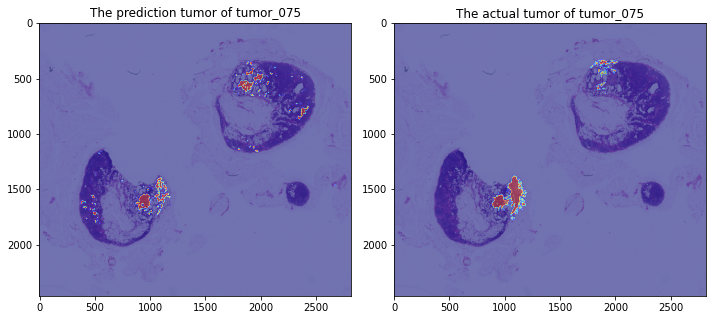

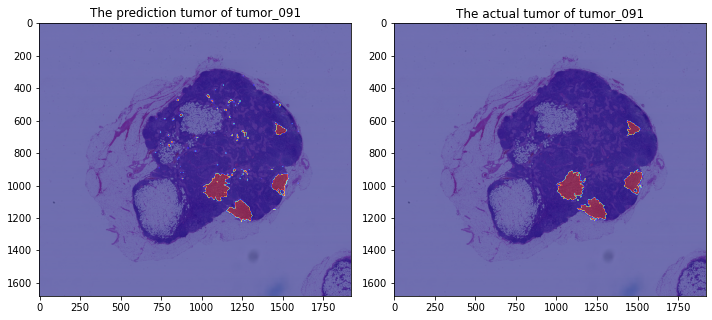

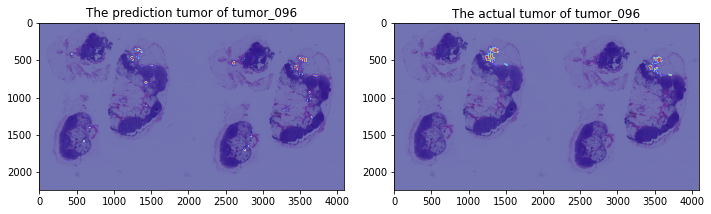

In [121]:
#Visualize prediction results on test images
for slide, mask, name in zip(test_slides, test_mask, test_names):
    name = name.split(".")[0]
    print(f"Now processing {name}!")
    with open(f"120319_project_tumor_folder/122821_test_predictions_of_{name}_no_preprocessing_with_rotation.pkl", 'rb') as f:
        pre_test, act_test = pickle.load(f)
    f.close()
    

    prediction_visualization(slide, mask, pre_test, act_test, 5, name, 0.7)